In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(rc={"figure.figsize": (30, 15)}, font_scale=1.5)

df = pd.read_csv('ECH_2019.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107871 entries, 0 to 107870
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   sexo                               107871 non-null  object
 1   edad                               107871 non-null  int64 
 2   ascendencia                        107871 non-null  object
 3   parentesco                         107871 non-null  object
 4   estado_laboral                     107871 non-null  object
 5   sueldo                             107871 non-null  int64 
 6   busca_otro_trabajo                 107871 non-null  object
 7   actividad                          107871 non-null  object
 8   asistencia alguna vez a enseñanza  107871 non-null  object
 9   edu preescolar                     107871 non-null  object
 10  edu primaria                       107871 non-null  object
 11  edu media                          107871 non-null  

In [2]:
df.sample(5)

,sexo,edad,ascendencia,parentesco,estado_laboral,sueldo,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof
100635,Hombre,57,Blanca,Jefe/a de hogar,Ocupados,0,No,Cría de ganado vacuno y búfalos,Sí,No asistió,"Sí, asistió",No asistió,No asistió,0,0,0,0
92516,Hombre,21,Blanca,Hijo/a solo del jefe/a,Inactivo: estudiante,0,0,.,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,Asiste actualmente,No asistió,0,No asistió
72223,Hombre,66,Blanca,Jefe/a de hogar,Ocupados,60000,No,Construcción de obras de arquitectura,Sí,No asistió,"Sí, asistió","Sí, asistió",No asistió,0,0,0,0
99940,Hombre,72,Blanca,Esposo/a o compañero/a,Inactivo: jubilado,0,0,.,Sí,No asistió,"Sí, asistió","Sí, asistió",No asistió,"Sí, asistió",No asistió,No asistió,No asistió
29100,Mujer,79,Blanca,Jefe/a de hogar,Inactivo: jubilado,0,0,.,Sí,No asistió,"Sí, asistió",0,No asistió,0,0,0,0


In [3]:
df = df[df['edad'] > 14]

### AJUSTANDO DATOS PARA ENTRENAR EL MODELO

Primero encodificamos las variables categóricas

In [4]:
from sklearn.preprocessing import LabelEncoder

mask = df.columns.difference(["edad", "sueldo", "hijos"])

df[mask] = df[mask].apply(LabelEncoder().fit_transform)

df.head(5)

,sexo,edad,ascendencia,parentesco,estado_laboral,sueldo,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof
0,1,76,3,6,4,0,0,0,1,1,3,0,2,0,0,0,0
1,1,22,3,9,7,0,0,0,1,2,3,3,2,2,2,0,2
2,0,65,3,6,9,0,1,100,1,1,3,3,3,2,2,0,2
3,1,59,1,1,9,15000,1,165,1,1,3,2,2,0,0,0,0
4,1,32,3,6,9,13000,1,38,1,2,3,3,2,0,0,0,0


Segundo normalizamos todos los atributos

In [5]:
from sklearn.preprocessing import StandardScaler

pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

,sexo,edad,ascendencia,parentesco,estado_laboral,sueldo,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof
0,0.923342,1.447397,0.161863,0.639775,-1.126100,-0.554432,-1.012268,-0.753874,0.089285,-1.083631,0.092094,-2.511677,-0.260152,-0.618771,-0.648323,-0.346507,-0.642309
1,0.923342,-1.254464,0.161863,1.862274,0.033608,-0.554432,-1.012268,-0.753874,0.089285,0.867267,0.092094,0.656705,-0.260152,1.207599,1.445709,-0.346507,1.392459
2,-1.083022,0.897018,0.161863,0.639775,0.806748,-0.554432,0.568752,0.131939,0.089285,-1.083631,0.092094,0.656705,2.308367,1.207599,1.445709,-0.346507,1.392459
3,0.923342,0.596811,-4.525701,-1.397723,0.806748,0.181083,0.568752,0.707718,0.089285,-1.083631,0.092094,-0.399422,-0.260152,-0.618771,-0.648323,-0.346507,-0.642309
4,0.923342,-0.754120,0.161863,0.639775,0.806748,0.083014,0.568752,-0.417265,0.089285,0.867267,0.092094,0.656705,-0.260152,-0.618771,-0.648323,-0.346507,-0.642309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88251,-1.083022,0.846983,0.161863,0.639775,-1.126100,-0.554432,-1.012268,-0.753874,0.089285,-1.083631,0.092094,-0.399422,-0.260152,-0.618771,-0.648323,-0.346507,-0.642309
88252,0.923342,1.097155,0.161863,-1.397723,0.033608,-0.554432,-1.012268,-0.753874,0.089285,-1.083631,0.092094,-2.511677,-0.260152,-0.618771,-0.648323,-0.346507,-0.642309
88253,0.923342,0.046432,-4.525701,0.639775,0.806748,-0.113123,0.568752,-0.417265,0.089285,-1.083631,0.092094,-0.399422,-0.260152,-0.618771,-0.648323,-0.346507,-0.642309
88254,-1.083022,-1.054326,-4.525701,-0.582724,0.806748,0.426254,0.568752,0.326818,0.089285,0.867267,0.092094,-0.399422,-0.260152,-0.618771,-0.648323,-0.346507,-0.642309


### Creamos un mapa de correlación para investigar la relación entre las variables

<AxesSubplot:>

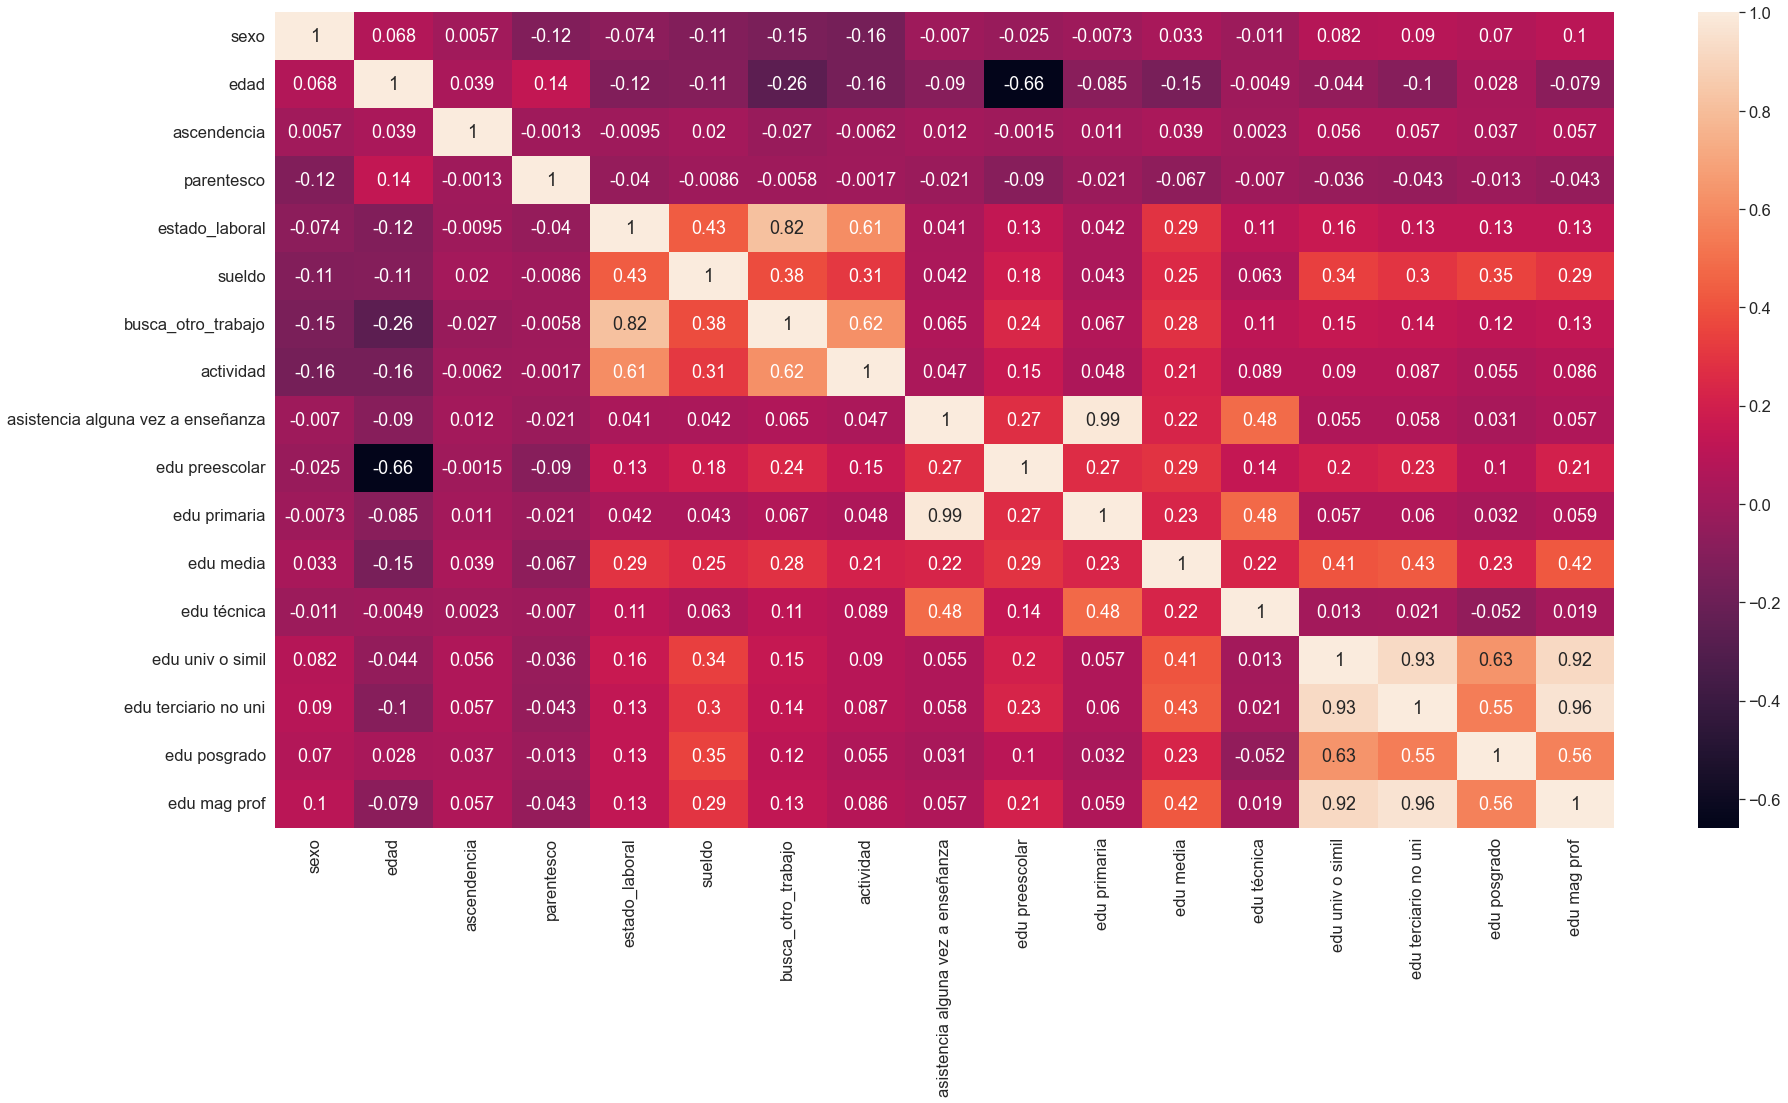

In [6]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

### DEFINIMOS LAS VARIABLES DEPENDIENTES E INDEPENDIENTES

In [7]:
from sklearn import preprocessing
norm = preprocessing.normalize

# Feautures
X = df['sueldo'].values.reshape(-1, 1)
X = norm(X, norm='l1')

y = df['busca_otro_trabajo'].to_numpy()

print('X shape', X.shape, '\nY shape', y.shape)

X shape (88256, 1) 
Y shape (88256,)


In [8]:
np.unique(y)

array([0, 1, 2])

### Dividimos los datos en un 30% de test y 70% de entrenamiento

In [9]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(61779, 1) (61779,)
(26477, 1) (26477,)


### DEFINIMOS ALGORITMO DE REFRESIÓN LOGISTICA Y VALOR DE CROSS VALIDATION PARA CADA FOLD

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(max_iter=20000)

clf = log_reg.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10)

scores

array([0.77067754, 0.767845  , 0.77135735, 0.76977113, 0.76591888,
       0.77305688, 0.76736544, 0.76475921, 0.77325779, 0.76974504])

Promedio de scores en el Cross Validation

In [12]:
scores.mean()

0.7693754263253881

In [13]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=10, shuffle=True)

# for train, test in kf.split(X):
#     print("%s %s" % (train, test))

Scores de cada clasificación

In [14]:
clf.score(X_test, y_test)

0.7683649960342939

In [15]:
clf.score(X_train, y_train)

0.7698085109826964

### DEFINIMOS UNA PREDICCIÓN Y LA APLICAMOS SOBRE EL MODELO

In [16]:
prediction = np.array([10000, 20000, 5000, 80000, 3000, 100,30000]).reshape(-1,1)
log_reg.predict(prediction)

array([1, 1, 1, 1, 1, 1, 1])

### INVESTIGAMOS LA EFECTIVIDAD DEL MODELO SOBRE LOS DATOS

In [17]:
from sklearn.metrics import accuracy_score

#Prediccion en Train
y_train_pred = log_reg.predict(X_train)

#Prediccion en Test
y_test_pred = log_reg.predict(y_test.reshape(-1, 1))

#Calculo el accuracy en Train
train_accuracy = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de entrenamiento:', train_accuracy)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.7698085109826964
% de aciertos sobre el set de evaluación: 0.9140008309098463


Determinamos la probabilidad de la predicción

In [18]:
probabilidades_prediccion = log_reg.predict_proba(prediction)
probabilidades_prediccion[:,1]

array([1., 1., 1., 1., 1., 1., 1.])